In [13]:
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from Signal_Analysis.features.signal import get_HNR
from sklearn import cluster, tree, ensemble, preprocessing
from tslearn.metrics import dtw

from vosk import Model

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

## data

0 i ------------------- from 0.30 to 0.42 sec, confidence: 100.00%
1 skymningen ---------- from 0.42 to 1.26 sec, confidence: 100.00%
2 en ------------------ from 1.35 to 1.50 sec, confidence: 100.00%
3 mycket -------------- from 1.50 to 1.80 sec, confidence: 100.00%
4 het ----------------- from 1.83 to 2.10 sec, confidence: 100.00%
5 dag ----------------- from 2.10 to 2.43 sec, confidence: 100.00%
6 i ------------------- from 2.43 to 2.52 sec, confidence: 100.00%
7 början -------------- from 2.52 to 2.79 sec, confidence: 100.00%
8 av ------------------ from 2.79 to 2.91 sec, confidence: 100.00%
9 juli ---------------- from 2.91 to 3.36 sec, confidence: 100.00%
10 lämnade ------------- from 3.36 to 3.99 sec, confidence: 100.00%
11 en ------------------ from 3.99 to 4.14 sec, confidence: 100.00%
12 ung ----------------- from 4.14 to 4.41 sec, confidence: 100.00%
13 man ----------------- from 4.41 to 4.68 sec, confidence: 100.00%
14 sin ----------------- from 4.68 to 4.92 sec, confidence

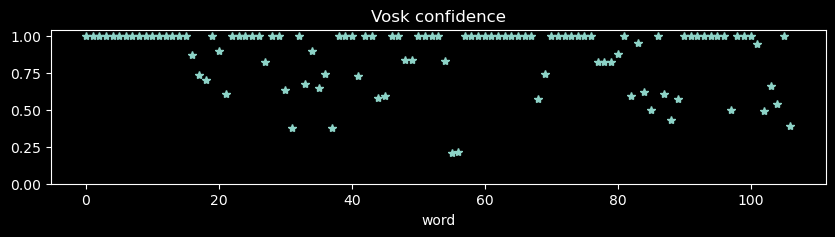

In [2]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"
Fs, audio = wavfile.read(audio_path)

fl = int(0.02 * Fs)

audio_norm = audio / audio.std()
frames_all, f_start_all = tools.split_frames(audio_norm, fl, Fs, vol_thr=0.1)
f_start_all = f_start_all[:-1]
frames_all = np.array(frames_all[:-1])

model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

if "words" not in locals():
    words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [3]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for i, w in enumerate(words):
    print(i, w["word"], w["vowels"], str(w["conf"] * 100) + "%")

0 i ['i'] 100.0%
1 skymningen ['y', 'i', 'e'] 100.0%
2 en ['e'] 100.0%
3 mycket ['y', 'e'] 100.0%
4 het ['e'] 100.0%
5 dag ['a'] 100.0%
6 i ['i'] 100.0%
7 början ['ö', 'a'] 100.0%
8 av ['a'] 100.0%
9 juli ['u', 'i'] 100.0%
10 lämnade ['ä', 'a', 'e'] 100.0%
11 en ['e'] 100.0%
12 ung ['u'] 100.0%
13 man ['a'] 100.0%
14 sin ['i'] 100.0%
15 kammare ['a', 'a', 'e'] 100.0%
16 som ['o'] 87.0501%
17 han ['a'] 73.67869999999999%
18 hörde ['ö', 'e'] 70.1671%
19 vid ['i'] 100.0%
20 s [] 89.281%
21 grand ['a'] 60.827799999999996%
22 steg ['e'] 100.0%
23 ut ['u'] 100.0%
24 på ['å'] 100.0%
25 gatan ['a', 'a'] 100.0%
26 och ['o'] 100.0%
27 började ['ö', 'a', 'e'] 81.8951%
28 långsamt ['å', 'a'] 100.0%
29 och ['o'] 100.0%
30 med ['e'] 63.4952%
31 samma ['a', 'a'] 37.5446%
32 obeslutsam ['o', 'e', 'u', 'a'] 100.0%
33 går ['å'] 67.3912%
34 bort ['o'] 89.4242%
35 mot ['o'] 64.3671%
36 jobb ['o'] 73.9019%
37 men ['e'] 37.8958%
38 lyckligtvis ['y', 'i', 'i'] 100.0%
39 slapp ['a'] 100.0%
40 han ['a'] 100.0%

In [4]:
words_conf1 = [w for w in words if w["conf"] >= 1]

segments, vowels_per_segment = tools.segment_by_words(
    words, audio, Fs, tools.VOWELS_SV, signal_pad=0.02
)
segments_conf1 = []

for i, w in enumerate(words):
    if w["conf"] >= 1:
        segments_conf1.append(segments[i])


## Look at one word

mycket
['y', 'e']
mfcc (19, 5)


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


x (6, 5)
[0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
0.3684210526315789


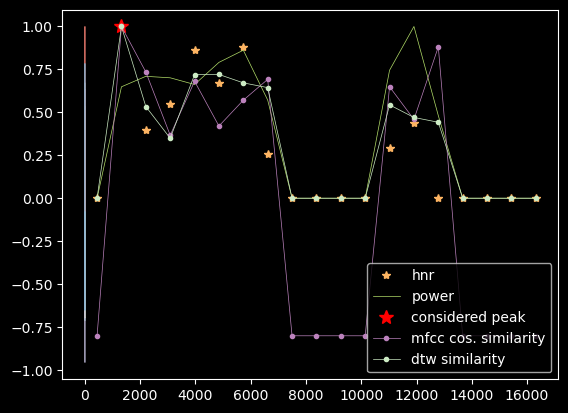

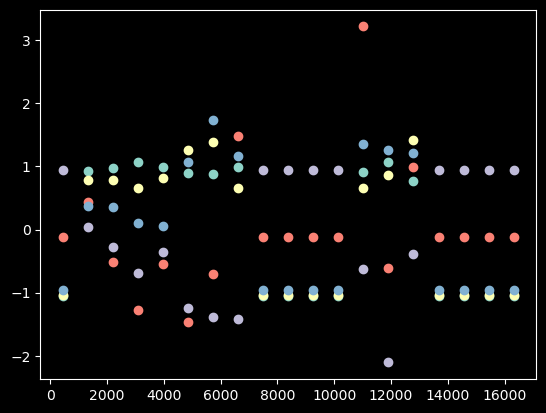

In [20]:
reload(tools)
k = 3
w = words_conf1[k]

print(w["word"])

x = segments_conf1[k] / segments_conf1[k].max()
x = np.concatenate((np.zeros(fl), x, np.zeros(fl)))
vowels = w["vowels"]
print(vowels)

frames, f_start = tools.split_frames(
    x, fl, Fs, overlap=0, vol_thr=0.1, print_info=False
)

peak_frames, hnr_frames = tools.HNR_short(frames, Fs, len(vowels))

hnr_env = tools.envelope(hnr_frames, 1, 1)
power_frames = np.array([np.mean(f**2) for f in frames])

mfcc_frames = np.array(tools.get_mfcc(frames, Fs, n=5))
sc_mfcc = preprocessing.StandardScaler()
mfcc_frames = sc_mfcc.fit_transform(mfcc_frames)

print("mfcc", mfcc_frames.shape)
# look at one peak
p = peak_frames[0]
f = frames[p]

# Cosine similarity of mel features
mfcc_peak = mfcc_frames[p]
mfcc_sim = np.array(
    [
        np.dot(mfcc_peak, f) / (np.linalg.norm(mfcc_peak) * np.linalg.norm(f))
        for f in mfcc_frames
    ]
)
# DTW to peak frame
dtw_diff = np.array([dtw(frames[p], f) for f in frames])

## Classify
x = mfcc_frames[[0, 1, 7, 8, 9, 11]]
y = np.zeros(len(x))
y[1] = 1

print("x", x.shape)
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)

inliers = clf.predict(mfcc_frames)

print(inliers)
print(sum(inliers / len(inliers)))


plt.figure()
plt.plot(np.arange(len(x)), x / x.max())
plt.plot(f_start + fl / 2, hnr_frames / hnr_frames.max(), "*", label="hnr")
plt.plot(f_start + fl / 2, power_frames / power_frames.max(), "-", label="power")

plt.plot(
    f_start[p] + fl / 2,
    hnr_frames[p] / hnr_frames.max(),
    "*r",
    markersize=10,
    label="considered peak",
)
plt.plot(
    f_start + fl / 2, mfcc_sim / mfcc_sim.max(), ".-", label="mfcc cos. similarity"
)
plt.plot(
    f_start + fl / 2, 1 - (dtw_diff / dtw_diff.max()), ".-", label="dtw similarity"
)

# plt.plot(f_start[inliers] + fl / 2, np.ones(len(inliers)) ** 2, "o", label="inlier")

plt.legend()
plt.show()

plt.figure()
plt.plot(f_start + fl / 2, mfcc_frames, "o")


### Look at every word

In [6]:
reload(tools)

grouped_frames = {v: [] for v in tools.VOWELS_SV}
grouped_features = {v: [] for v in tools.VOWELS_SV}
grouped_hnr = {v: [] for v in tools.VOWELS_SV}

for k, w in enumerate(words_conf1):
    word = w["word"]

    x = segments_conf1[k] / segments_conf1[k].max()
    x = np.concatenate((np.zeros(fl), x, np.zeros(fl)))
    vowels = w["vowels"]

    # MAYBE SHOULDNT VOL THRESHOLD HERE, FALSE PEAKS
    frames, f_start = tools.split_frames(
        x, fl, Fs, overlap=0, vol_thr=0.1, print_info=False
    )

    peak_frames, hnr_frames = tools.HNR_short(frames, Fs, len(vowels))

    for i, p in enumerate(peak_frames):
        v = vowels[i]
        f = frames[p]
        grouped_frames[v].append(f)
        mfcc = tools.get_mfcc(f, Fs)
        grouped_features[v].append(mfcc)
        grouped_hnr[v].append(hnr_frames[p])


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [7]:
print("# frames per vowel")
for v in grouped_frames.keys():
    print(v, len(grouped_frames[v]))

# features_df = pd.DataFrame.from_dict(grouped_features)

# display(features_df.head())

# frames per vowel
y 4
e 20
å 3
o 10
a 31
ä 6
i 16
u 8
ö 4


(20, 50)
(0, array([7.62939453e-06, 9.60422686e+01, 1.00780938e+02, 5.55647374e+01,
       8.20260017e+01, 4.97791567e+01, 1.45912605e+02, 9.07706322e+01,
       5.01913210e+01, 8.35977511e+01, 7.55201184e+01, 1.43450560e+02,
       8.08674925e+01, 7.69081391e+01, 1.10518296e+02, 8.82512494e+01,
       9.06135727e+01, 6.42882511e+01, 7.45667009e+01, 8.63648320e+01]))
(1, array([ 96.04226861,   0.        ,  79.51869847,  71.83187913,
        84.51312647,  91.66763012, 121.7906072 , 104.30389801,
        85.9299607 ,  91.35093974,  85.77940688, 100.9463333 ,
        92.17356787,  79.87356841,  76.88324329,  67.05961112,
        90.7077594 ,  80.1479599 , 118.81912205,  60.76970277]))
(1, array([100.78093827,  79.51869847,   0.        ,  68.00592875,
        67.26482624, 102.63552756,  93.96673791,  96.54829698,
        83.7052609 ,  85.46823889,  70.85623101, 119.94465286,
        56.46491046,  73.69097092,  52.53573229,  31.543346  ,
        66.82253436,  95.43616754, 132.21264284,  62.

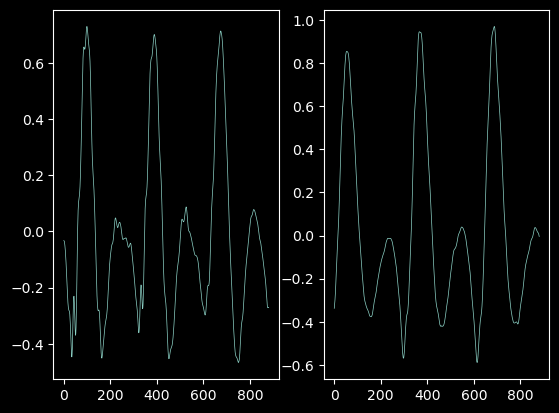

17.230688923294835 14.332656138477613


In [8]:
v = "e"
n_clust = 2
frames = grouped_frames[v]
X = np.array(grouped_features[v])
# X = np.array(np.array(grouped_hnr[v]).reshape(-1, 1))
print(X.shape)
km = cluster.Birch(n_clusters=n_clust).fit(X)

X_cluster = km.transform(X)

in_cluster = km.predict(X)

for r in zip(in_cluster, X_cluster):
    print(r)

X_in = [X_cluster[k] for k in range(len(in_cluster)) if in_cluster[k]]
print(len(X_in))

frames_in = [frames[k] for k in range(len(in_cluster)) if in_cluster[k]]
frames_out = [frames[k] for k in range(len(in_cluster)) if not in_cluster[k]]

hnr_in = [grouped_hnr[v][k] for k in range(len(in_cluster)) if in_cluster[k]]
hnr_out = [grouped_hnr[v][k] for k in range(len(in_cluster)) if not in_cluster[k]]


plt.figure()
plt.subplot(121)
plt.plot(frames_in[0])
plt.subplot(122)
plt.plot(frames_out[0])
plt.show()
print(hnr_in[0], hnr_out[0])

14.767957541132862 13.035610627394249


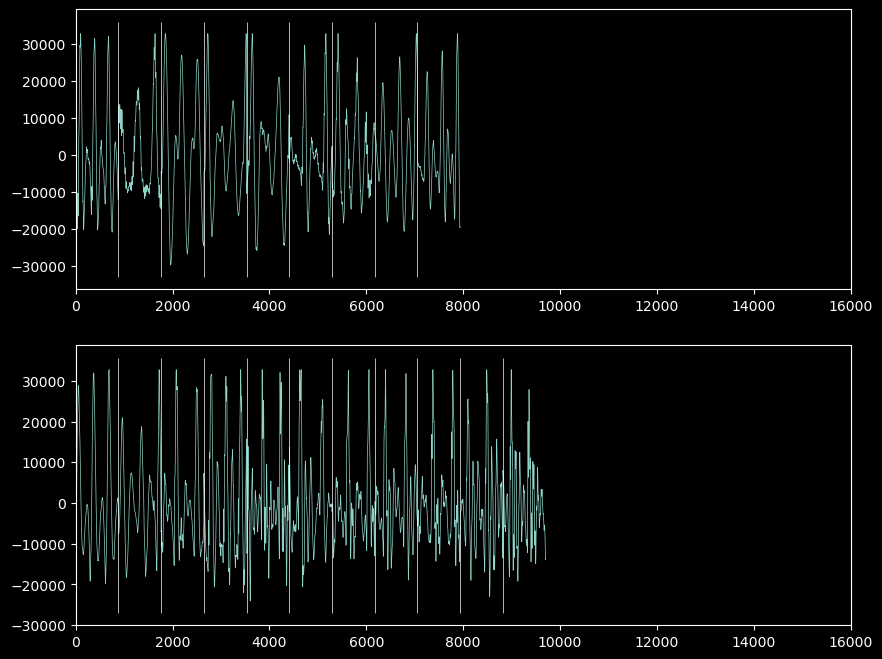

In [9]:
stitched = {}
stitched[v] = []

stitched[v].append(tools.stitch_frames(frames_in))
stitched[v].append(tools.stitch_frames(frames_out))

plt.figure(figsize=(10, 8))
for i in range(n_clust):
    plt.subplot(2, 1, i + 1)
    plt.plot(stitched[v][i])
    plt.xlim(0, 16000)
    plt.vlines(np.arange(stop=len(stitched[v][i]), step=fl), *plt.ylim())

    wavfile.write(f"output/clust{n_clust}_{i}.wav", Fs, stitched[v][i])

print(np.mean(hnr_in), np.mean(hnr_out))

## outliers?

inliers 70.0 %


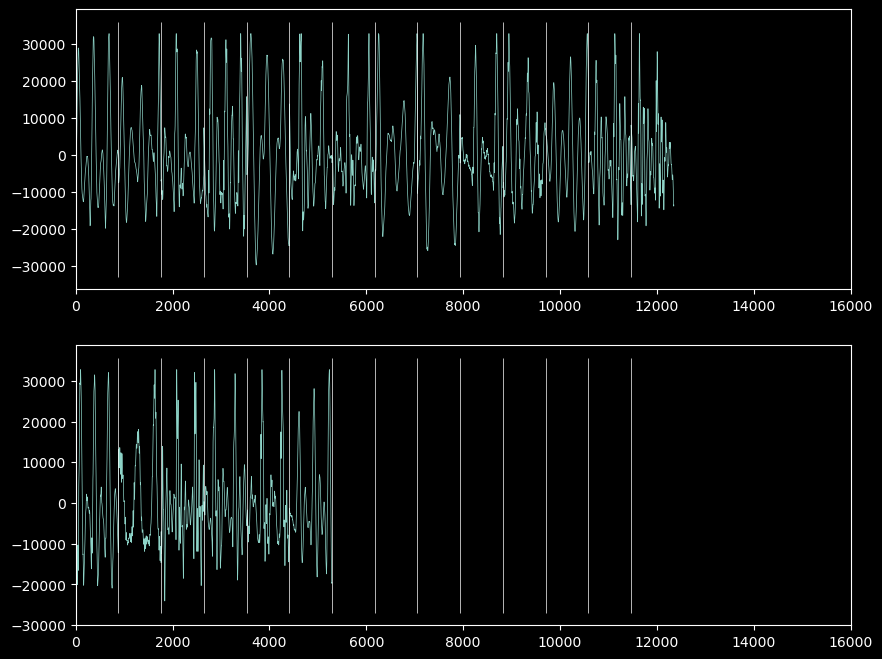

In [10]:
clf = ensemble.IsolationForest(random_state=0)
clf.fit(X)

inliers = clf.predict(X) > 0

print(f"inliers {np.around(100*sum(inliers)/len(X))} %")

frames_inlier = []
frames_outlier = []
for k in range(len(inliers)):
    if inliers[k]:
        frames_inlier.append(grouped_frames[v][k])
    else:
        frames_outlier.append(grouped_frames[v][k])

stitched_in = tools.stitch_frames(frames_inlier)
stitched_out = tools.stitch_frames(frames_outlier)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(stitched_in)
plt.xlim(0, 16000)
plt.vlines(np.arange(stop=len(stitched_in), step=fl), *plt.ylim())
plt.subplot(2, 1, 2)
plt.plot(stitched_out)
plt.xlim(0, 16000)
plt.vlines(np.arange(stop=len(stitched_in), step=fl), *plt.ylim())

wavfile.write("output/liers_in.wav", Fs, stitched_in)
wavfile.write("output/liers_out.wav", Fs, stitched_out)
